# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [1]:
import sys
import json
from keras.models import Model, model_from_json
from volume_estimator import VolumeEstimator
from depth_estimation.custom_modules import *
from food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# Paths to model archiecture/weights
depth_model_architecture = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
depth_model_weights = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = '../models/segmentation/mask_rcnn_food_segmentation.h5'
classification_model_weights = '../models/classification/simple_model_weights.pth'
input_image = '../assets/readme_assets/examples/rice_example.jpg'

Using TensorFlow backend.
/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use tf.cast instead.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights ../models/segmentation/mask_rcnn_food_segmentation.h5


[*] Creating intrinsics matrix from given FOV: 70


/home/amrit/projects/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  cab_x = (mb[1] - tb * mb[0] - ma[1] + ta * ma[0]) / (ta - tb)
/home/amrit/projects/food_volume_estimation/food_volume_estimation/ellipse_detection/ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  cab_y = (ta * mb[1] - tb * ma[1] + ta * tb * (ma[0] - mb[0])) / (ta - tb)


[*] Ellipse parameters: (109.64060974121094, 61.24528503417969, 74.5, 43.64646464646464, 0.043876992368572676)
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3042935188278074, 0.0192909425749494, -0.5010998439788599, -0.8651744366883086]
[*] Estimated volume: 0.39650976628538276 L


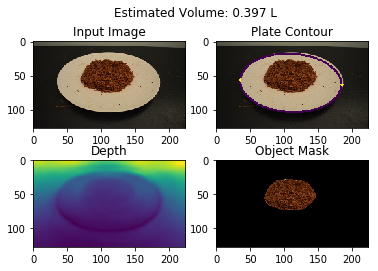

In [3]:
# Estimate volumes in input image
plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

In [4]:
volume = outputs_list[0][0] * 1000
volume

0.39650976628538276

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np

# Define the class names
class_names = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']

# Define the densities corresponding to each class name
class_densities = {
    'Bread': 0.75,
    'Dairy product': 0.6,
    'Dessert': 0.8,
    'Egg': 0.65,
    'Fried food': 0.85,
    'Meat': 0.9,
    'Noodles/Pasta': 0.7,
    'Rice': 0.72,
    'Seafood': 0.88,
    'Soup': 0.78,
    'Vegetable/Fruit': 0.5
}

# Define the ResNet34 model
model = models.resnet34(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 11)  # Output layer with 11 classes

# Load pretrained weights
model.load_state_dict(torch.load(classification_model_weights, map_location=torch.device('cpu')))
model.eval()

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to predict the class of an input image and retrieve the density
# def predict_image(image_path, model, transform, class_names, class_densities):
#     image = Image.open(image_path)
#     image = transform(image).unsqueeze(0)  # Add batch dimension
#     with torch.no_grad():
#         outputs = model(image)
#         _, predicted = torch.max(outputs, 1)
#         predicted_class_index = predicted.item()
#         predicted_class_name = class_names[predicted_class_index]
#         density = class_densities[predicted_class_name]
#     return predicted_class_index, predicted_class_name, density

# Example usage
# input_image = '../../assets/readme_assets/examples/rice_example.jpg'
# predicted_class_index, predicted_class_name, density = predict_image(input_image, model, transform, class_names, class_densities)
# print(f'Predicted class index: {predicted_class_index}')
# print(f'Predicted class name: {predicted_class_name}')
# print(f'Density: {density}')


In [6]:
total_mass = volume * density

In [7]:
total_mass # in kg

0.28548703172547557

In [4]:
# Dictionary mapping class names to calories per 100g
calories_per_100g = {
    'Bread': 265,
    'Dairy product': 150,
    'Dessert': 250,
    'Egg': 155,
    'Fried food': 330,
    'Meat': 250,
    'Noodles/Pasta': 138,
    'Rice': 130,
    'Seafood': 85,
    'Soup': 30,
    'Vegetable/Fruit': 30
}

# Total mass in kilograms
# total_mass_kg = total_mass  

# # Calculate total calories
# total_calories = calories_per_100g[predicted_class_name] * 10 * total_mass_kg


# print("Total calories for the given total mass:", total_calories)

In [10]:
%matplotlib notebook



# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()

<IPython.core.display.Javascript object>

/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/pythreejs/traits.py:191: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.009380886347167819, -0.014420058529548425,…

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.01199383778658516, 0.1735977132007748, 0.…

<IPython.core.display.Javascript object>

In [13]:
# Function to predict the class of an input image and retrieve the density
def predict_image(image_path, model, transform, class_names, class_densities):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class_index = predicted.item()
        predicted_class_name = class_names[predicted_class_index]
        density = class_densities[predicted_class_name]
    return predicted_class_index, predicted_class_name, density


def calculate_volume(image_path,plate_diameter=0.35):
    print("here")
    outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)
    volume = outputs_list[0][0] * 1000
    predicted_class_index, predicted_class_name, density = predict_image(input_image, model, transform, class_names, class_densities)
    total_mass = volume * density
    total_calories = calories_per_100g[predicted_class_name] * 10 * total_mass
    
    return total_calories

calories_function = lambda image_path: calculate_volume(image_path)

In [14]:
# Create the Gradio interface
import gradio as gr
iface = gr.Interface(calories_function, 
                     inputs="image",
                     outputs="text",
                     title="Calories Estimator",
                     capture_session=True)  # Add capture_session=True to fix the error

iface.launch()


IMPORTANT: You are using gradio version 2.0.7, however version 3.14.0 is available, please upgrade.
--------
Running locally at: http://127.0.0.1:7864/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


(<Flask 'gradio.networking'>, 'http://127.0.0.1:7864/', None)

[2024-03-19 21:39:32,574] ERROR in app: Exception on /api/predict/ [POST]
Traceback (most recent call last):
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask_cors/extension.py", line 176, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/amrit/anaconda3/envs/volume-estimation/lib/python3.6/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/amrit/anaconda3/envs/volume-esti

here
[*] Creating intrinsics matrix from given FOV: 70


: 